# Boundary vector score (BVS) - workflow and tests

Implementation of Debora's boundary vector score script in python

In [251]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [252]:
# Set up basics
import sys, os
import numpy as np 
from collections import OrderedDict
# Make plots pretty 
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style='white')
%config InlineBackend.figure_format = 'retina'

import datajoint as dj

In [253]:
# Load base schema
schema = dj.schema(dj.config['dj_imaging.database'])
schema.spawn_missing_classes()

### Load an example ... 

In [329]:
current_session = "64c4def9426b030b"
session_key = Session.proj() & f'session_name = "{current_session}"'

cell_param_dict = OrderedDict([('ang_params_id', 'A'),
                             ('border_params_id', 'A'),
                             ('channel', 'primary'),
                             ('field_params_id', 'A'),
                             ('grid_params_id', 'A'),
                             ('map_params_id', 'A'),
                             ('noise_calc_id', 'A'),
                             ('s_t_params_id', 'A'),
                             ('shuffle_params_id', 'A'),
                             ('signal_type', 'spikes'),
                             ('spike_filter_id', 'A'),
                             ('trackingparams_id', 'A')])

In [330]:
some_ratemaps = Ratemap & session_key & cell_param_dict

In [333]:
cell = 106 # 80
ratemap_entry = (some_ratemaps & f'cell_id = {cell}').fetch1()

In [334]:
rm      = np.ma.array(ratemap_entry['ratemap'], mask = ratemap_entry['mask_rm'])
rm_nans = np.ma.filled(rm, fill_value=np.nan).astype(np.float64)

In [335]:
rm_nans.shape

(32, 32)

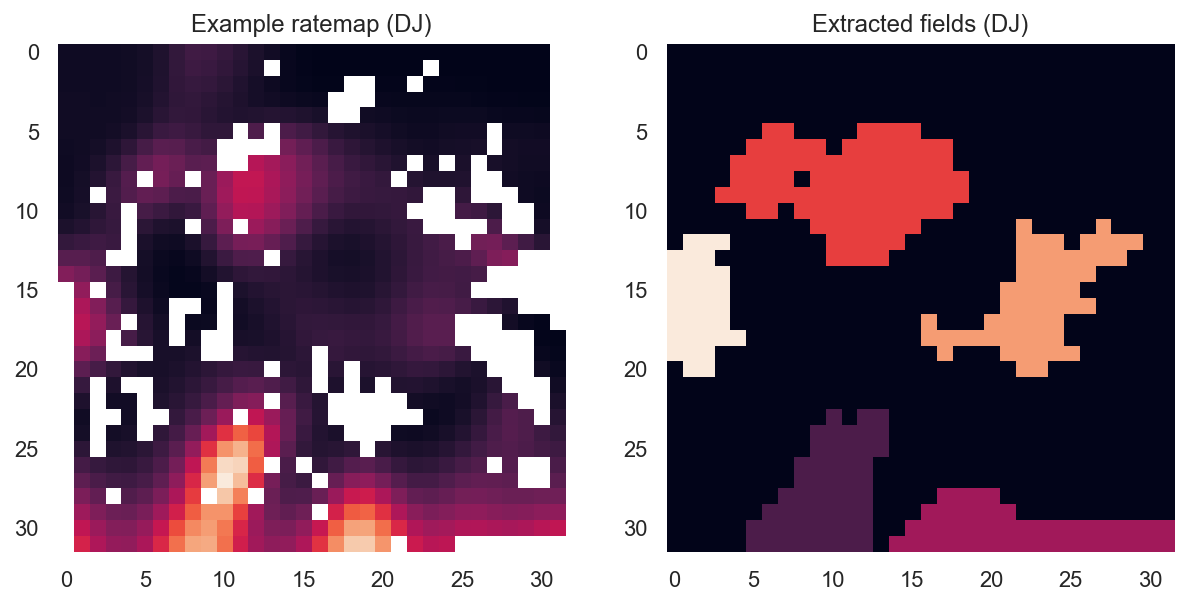

In [336]:
figure = plt.figure(figsize=(10,5))
ax = figure.add_subplot(121)
ax.imshow(rm_nans)
ax.set_title('Example ratemap (DJ)')
ax = figure.add_subplot(122)
ax.imshow(ratemap_entry['fields_map'])
ax.set_title('Extracted fields (DJ)')
sns.despine(left=True,bottom=True)

### Functions

In [337]:
from bvs.bv_score import calc_bv_score
from bvs.detect_fields import detect_fields

Thresholds
----------
fieldDetectionThresh: 40.662274631199054
fieldInclusionThresh: 63.787123505365315
minBin: 16

Fields
------
Detected 4 fields
Maxima of detected regions:   [ 62.08329854  43.9590937   59.05523883 129.63934972]
Length of detected regions:   [ 21   2   9 116]
1 fields remain



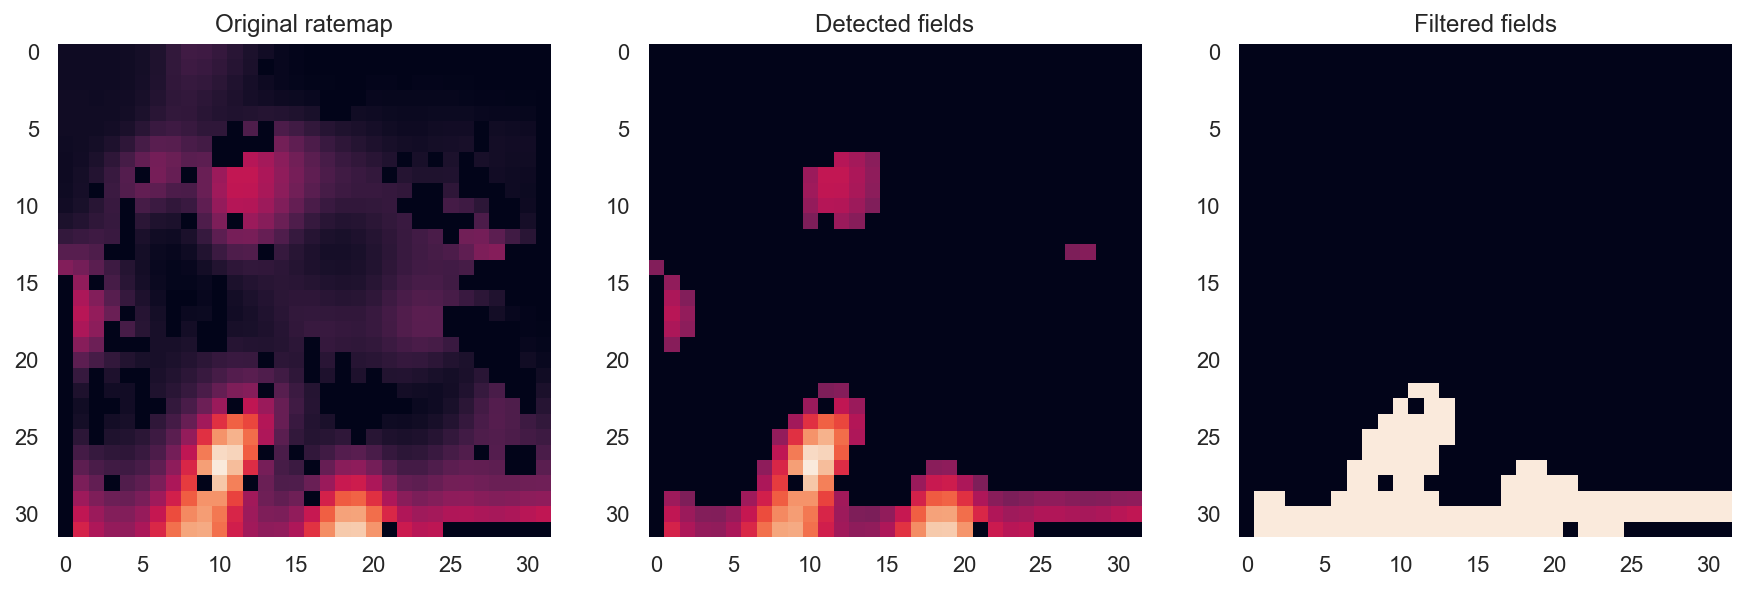

In [338]:
fieldmap, remaining_fields = detect_fields(rm_nans, minBin=16, show_plots=True, debug=True)

Barwidth ranges:  [1 2 3 4 5]
r value: 0.5
Looping over horizontal bars ... 
Score increased to -0.075 | yPos: 0 (barwidth: 1)
Score increased to -0.010 | yPos: 22 (barwidth: 1)
Score increased to  0.022 | yPos: 23 (barwidth: 1)
Score increased to  0.087 | yPos: 24 (barwidth: 1)
Score increased to  0.119 | yPos: 25 (barwidth: 1)
Score increased to  0.183 | yPos: 27 (barwidth: 1)
Score increased to  0.216 | yPos: 28 (barwidth: 1)
Score increased to  0.700 | yPos: 29 (barwidth: 1)
Score increased to  0.925 | yPos: 30 (barwidth: 1)

Looping over vertical bars ... 
Score increased to -0.075 | xPos: 0 (barwidth: 1)
Score increased to  0.022 | xPos: 1 (barwidth: 1)
Score increased to  0.087 | xPos: 7 (barwidth: 1)
Score increased to  0.151 | xPos: 8 (barwidth: 1)
Score increased to  0.216 | xPos: 10 (barwidth: 1)

Final boundary vector score: 0.9254032258064516 (horizontal)


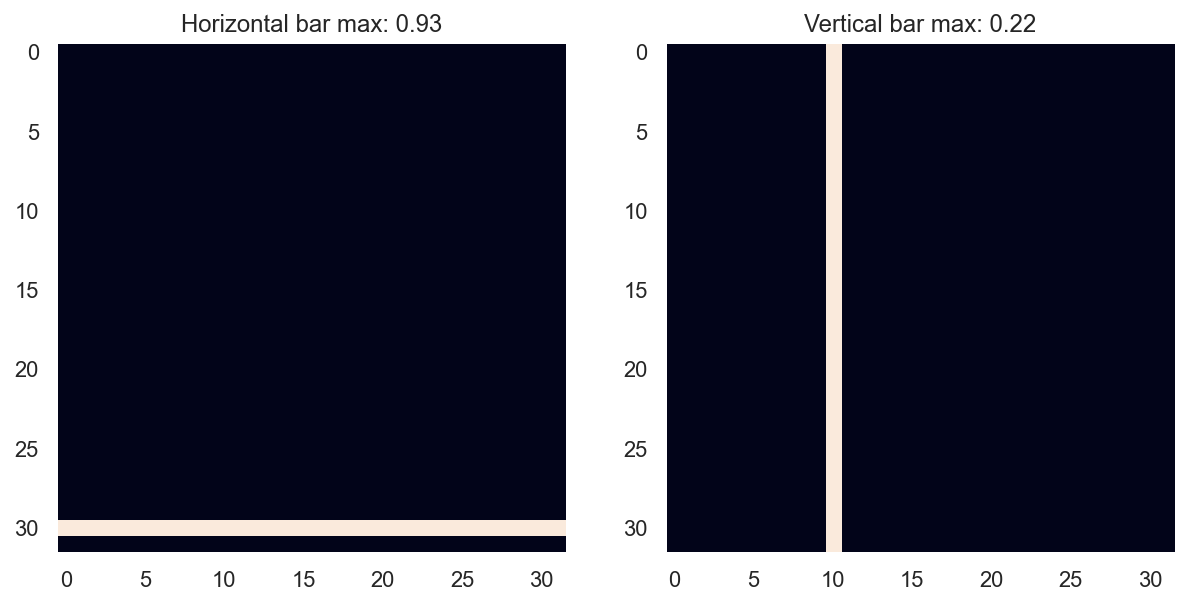

In [339]:
bvs, bvs_x, bvs_y, max_orientation = calc_bv_score(fieldmap, r=.5, barwidth_max=5, show_plots=True, debug=True)

In [340]:
bvs # max of x and y 

0.9254032258064516

### Save for matlab

In [341]:
from scipy.io import savemat

In [342]:
rm_dict = {'map': rm_nans, 
           'dj_session_name': current_session, 
           'dj_cell_id': cell, 
           'dj_cell_param_dict': cell_param_dict, 
           'xScore_python' : bvs_x['score_x'],
           'yScore_python' : bvs_y['score_y']}
savemat(f'matlab/test_data/cell_{cell}_{current_session}.mat',rm_dict)
print(f'Saved under \nmatlab/test_data/cell_{cell}_{current_session}.mat')

Saved under 
matlab/test_data/cell_106_64c4def9426b030b.mat


### Run bvs calculation over opexebo field map

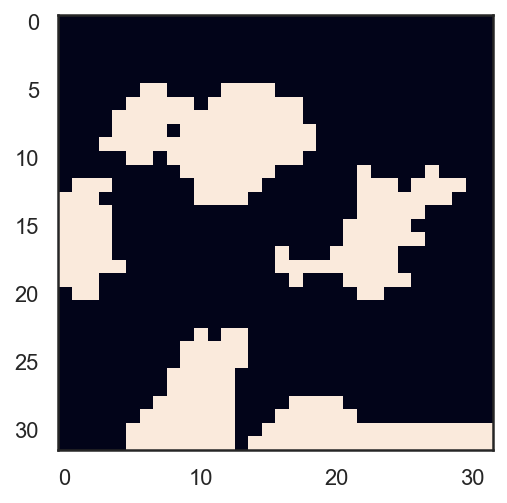

In [343]:
fieldmap_opex = ratemap_entry['fields_map'].copy()
fieldmap_opex[fieldmap_opex>0] = 1
plt.imshow(fieldmap_opex)

Barwidth ranges:  [1 2 3 4 5]
r value: 0.5
Looping over horizontal bars ... 
Score increased to -0.154 | yPos: 0 (barwidth: 1)
Score increased to  0.039 | yPos: 5 (barwidth: 1)
Score increased to  0.233 | yPos: 6 (barwidth: 1)
Score increased to  0.297 | yPos: 7 (barwidth: 1)
Score increased to  0.362 | yPos: 9 (barwidth: 1)
Score increased to  0.652 | yPos: 30 (barwidth: 1)
Score increased to  0.684 | yPos: 31 (barwidth: 1)

Looping over vertical bars ... 
Score increased to  0.072 | xPos: 0 (barwidth: 1)
Score increased to  0.136 | xPos: 1 (barwidth: 1)
Score increased to  0.168 | xPos: 8 (barwidth: 1)
Score increased to  0.297 | xPos: 9 (barwidth: 1)
Score increased to  0.362 | xPos: 10 (barwidth: 1)
Score increased to  0.426 | xPos: 12 (barwidth: 1)

Final boundary vector score: 0.6844758064516129 (horizontal)


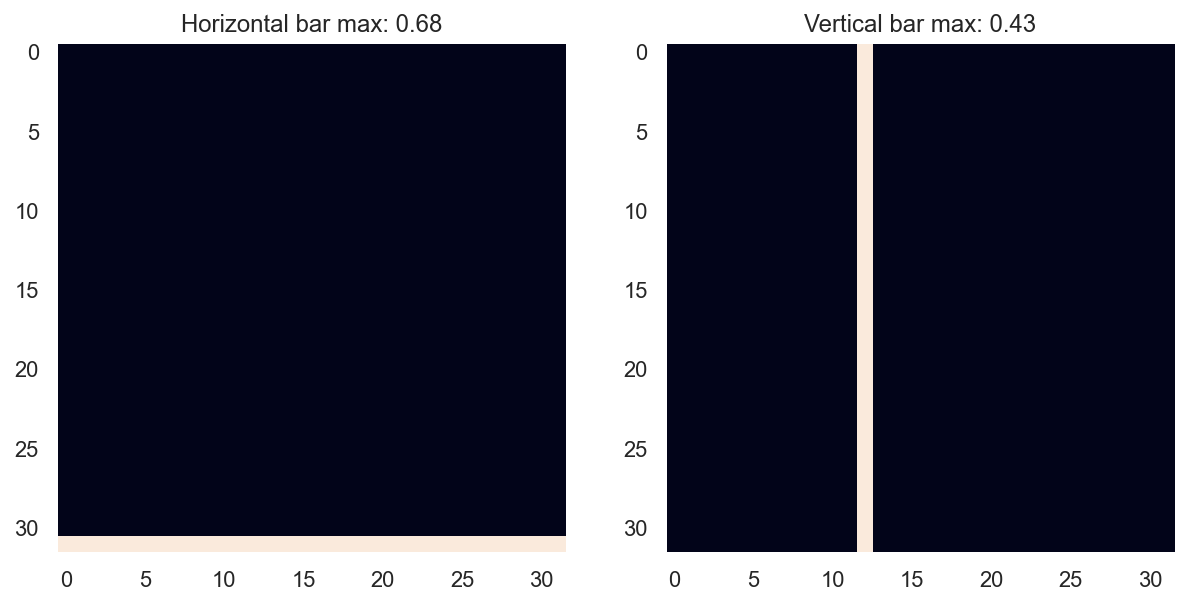

In [344]:
bvs, bvs_x, bvs_y, max_orientation = calc_bv_score(fieldmap_opex, r=.5, barwidth_max=5, show_plots=True, debug=True)

In [345]:
bvs_x

{'score_x': 0.6844758064516129,
 'bar_width': 1,
 'ypos': 31.5,
 'ypos_rel': 0.984375,
 'bar_map': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 1., 1., ..., 1., 1., 1.]])}